# **Import Libraries**

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import f1_score , confusion_matrix, classification_report
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# **Train Preprocessing**

In [9]:
train_data_path = '/kaggle/input/fruits-date/dataset/train'
test_data_path = '/kaggle/input/fruits-date/dataset/test'
images = []
labels =[]
categories = ['Apple' , 'Banana' , 'grapes' , 'Mango' , 'Strawberry']
directories = os.listdir(train_data_path) 
for directory in directories :
    items_path = os.path.join(train_data_path,directory)
    for img_name in os.listdir(items_path) :
        img_path = os.path.join(items_path , img_name)
        img = load_img(img_path , target_size=(100 , 100))
        img_array = img_to_array(img) 
        img_array /= 255.0 
        images.append(img_array)
        labels.append(directory)

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels) 

# Perform one-hot encoding
labels = to_categorical(labels)

# **Augment Data**

In [ ]:
additional_augmented_data = []
additional_augmented_labels = []
for img, label in zip(images, labels):
    additional_augmented_img = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.4,
        height_shift_range=0.4,
        shear_range=0.4,
        zoom_range=0.4,
        horizontal_flip=True,
        fill_mode='nearest'
    ).random_transform(img) 
    additional_augmented_data.append(additional_augmented_img)
    additional_augmented_labels.append(label)

#merge two lists
images = np.concatenate((images, additional_augmented_data), axis=0)
labels = np.concatenate((labels, additional_augmented_labels), axis=0)

# **Visualize Images**

/opt/conda/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


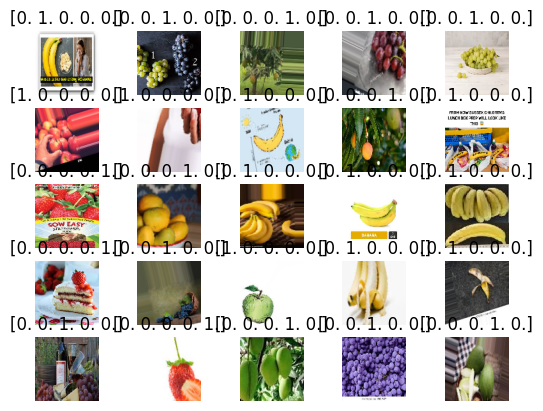

In [4]:
for n , i in enumerate(list(np.random.randint(0,len(images),25))) : 
    plt.subplot(5,5,n+1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(labels[i])

# **Split data**

In [11]:
X_train, X_val, y_train, y_val = train_test_split(images, labels , test_size=0.3, random_state=42)
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)
print(f'X_train shape is {X_train.shape}')
print(f'X_val shape is {X_val.shape}')
print(f'y_train shape is {y_train.shape}')
print(f'y_val shape is {y_val.shape}')

X_train shape is (13860, 100, 100, 3)
X_val shape is (5940, 100, 100, 3)
y_train shape is (13860, 5)
y_val shape is (5940, 5)


# **Test Preprocessing**

In [12]:
test_data_csv = '/kaggle/input/test-dataaaa/test data.csv'
test_labels = pd.read_csv(test_data_csv )
test_labels = test_labels.drop(test_labels.columns[0] , axis = 1)
test_imgs = []
imgs_paths = os.listdir(test_data_path)
for img_path in imgs_paths :
    items_path = os.path.join(test_data_path,img_path)
    img = load_img(items_path , target_size=(100 , 100))
    img_array = img_to_array(img) # Convert image to a NumPy array
    img_array /= 255.0
    test_imgs.append(img_array) 
X_test = np.array(test_imgs)
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(test_labels)
categorical_labels = to_categorical(encoded_labels)
y_test = np.array(categorical_labels)
print(f'X_test shape is {X_test.shape}')
print(f'y_test shape is {y_test.shape}')

X_test shape is (100, 100, 100, 3)
y_test shape is (100, 5)


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# **CNN Model From Scratch**

Model Details are:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 98, 98, 256)       7168      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 49, 49, 256)       0         
 g2D)                                                            
                                                                 
 batch_normalization_8 (Bat  (None, 49, 49, 256)       1024      
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 47, 47, 128)       295040    
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 23, 23, 128)       0         
 g2D)                                                            
                                   

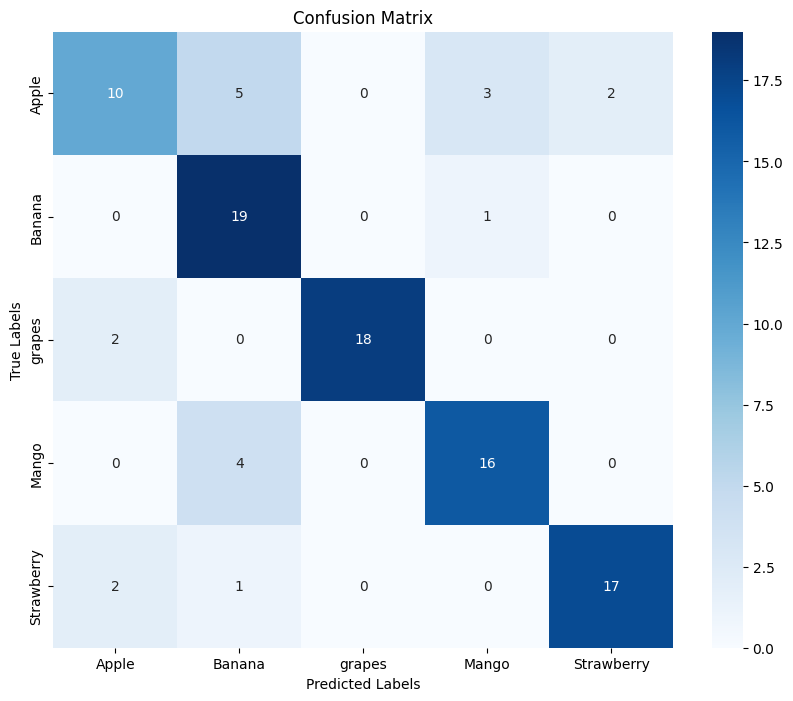

In [14]:
# Build the model
num_classes = 5
model = models.Sequential()
model.add(layers.Conv2D(256, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.BatchNormalization()) #normalize (calculate main and standard diviation) the output of last layer to avoid overfit
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Flatten()) #convert input to 1D array
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(rate=0.5)) #drop out number of neurons
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(rate=0.6))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model details
print('Model Details are:')
print(model.summary())

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

# Train the model
ThisModel = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Predictions, Confusion Matrix, and Classification Report (as in previous examples)
y_pred = model.predict(X_test)

# Convert predictions to one-hot encoding
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# **2nd Train Preprocessing**

In [2]:
train_data_path = '/kaggle/input/fruits-date/dataset/train'
test_data_path = '/kaggle/input/fruits-date/dataset/test'
images = []
labels =[]
categories = ['Apple' , 'Banana' , 'grapes' , 'Mango' , 'Strawberry']
directories = os.listdir(train_data_path) 
for directory in directories :
    items_path = os.path.join(train_data_path,directory)
    for img_name in os.listdir(items_path) :
        img_path = os.path.join(items_path , img_name)
        img = load_img(img_path , target_size=(224 , 224))
        img_array = img_to_array(img) 
        img_array /= 255.0 
        images.append(img_array)
        labels.append(directory)

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels) 

# Perform one-hot encoding
labels = to_categorical(labels)

# **2nd Splitting Data**

In [3]:
X_train, X_val, y_train, y_val = train_test_split(images, labels , test_size=0.3, random_state=42)
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)
print(f'X_train shape is {X_train.shape}')
print(f'X_val shape is {X_val.shape}')
print(f'y_train shape is {y_train.shape}')
print(f'y_val shape is {y_val.shape}')

X_train shape is (6930, 224, 224, 3)
X_val shape is (2970, 224, 224, 3)
y_train shape is (6930, 5)
y_val shape is (2970, 5)


# **2nd Test Preprocessing**

In [5]:
test_data_csv = '/kaggle/input/test-dataaaa/test data.csv'
test_labels = pd.read_csv(test_data_csv )
test_labels = test_labels.drop(test_labels.columns[0] , axis = 1)
test_imgs = []
imgs_paths = os.listdir(test_data_path)
for img_path in imgs_paths :
    items_path = os.path.join(test_data_path,img_path)
    img = load_img(items_path , target_size=(224 , 224))
    img_array = img_to_array(img) # Convert image to a NumPy array
    img_array /= 255.0
    test_imgs.append(img_array) 
X_test = np.array(test_imgs)
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(test_labels)
categorical_labels = to_categorical(encoded_labels)
y_test = np.array(categorical_labels)
print(f'X_train shape is {X_test.shape}')
print(f'y_test shape is {y_test.shape}')

X_train shape is (100, 224, 224, 3)
y_test shape is (100, 5)


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# **Vision Transformer**

Model Details are:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 512)          393728    ['input_1[0][0]']             
                                                                                                  
 reshape (Reshape)           (None, 196, 512)             0         ['conv2d[0][0]']              
                                                                                                  
 tf.__operators__.add (TFOp  (None, 196, 512)             0         ['reshape[0][0]']             
 Lambda)                                                                   

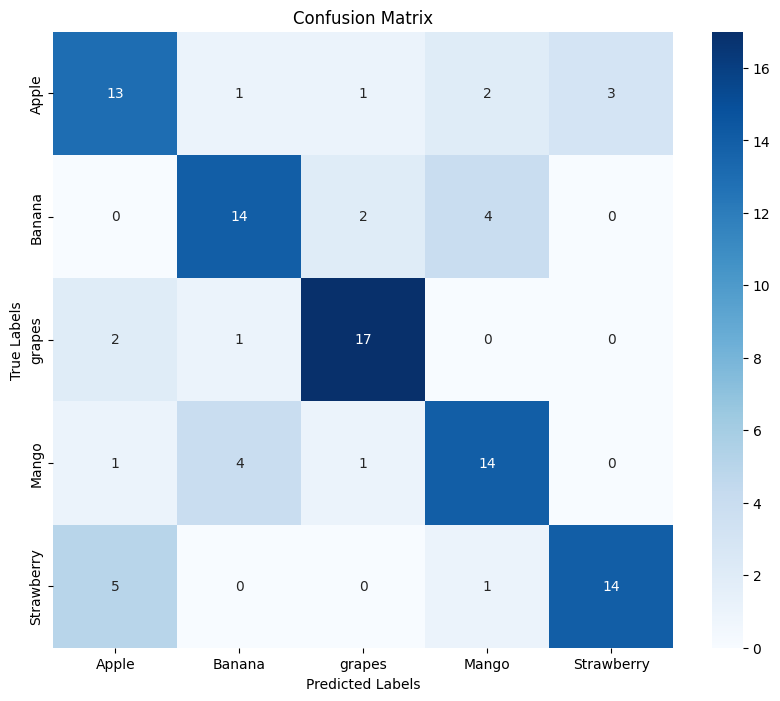

Classification Report:
              precision    recall  f1-score   support

       Apple       0.62      0.65      0.63        20
      Banana       0.70      0.70      0.70        20
      grapes       0.81      0.85      0.83        20
       Mango       0.67      0.70      0.68        20
  Strawberry       0.82      0.70      0.76        20

    accuracy                           0.72       100
   macro avg       0.72      0.72      0.72       100
weighted avg       0.72      0.72      0.72       100



In [6]:
# Define the Vision Transformer model from scratch
def create_vit_model(image_size, num_classes, patch_size, num_patches, embedding_dim, num_heads, mlp_dim, dropout_rate):
    inputs = layers.Input(shape=image_size)

    # Patching layer
    patching = layers.Conv2D(embedding_dim, kernel_size=patch_size, strides=patch_size, padding="valid")(inputs)
    reshaped_patches = layers.Reshape((num_patches, embedding_dim))(patching)

    # Positional encoding
    position_embedding = layers.Embedding(input_dim=num_patches, output_dim=embedding_dim)(tf.range(num_patches))
    positional_encoded_patches = reshaped_patches + position_embedding

    # Transformer Encoder
    for _ in range(num_heads):
        attention_output = layers.MultiHeadAttention(num_heads=1, key_dim=embedding_dim)(positional_encoded_patches, positional_encoded_patches)
        residual1 = layers.Add()([attention_output, positional_encoded_patches])
        normalized1 = layers.LayerNormalization(epsilon=1e-6)(residual1)

        mlp_output = layers.Dense(mlp_dim, activation="relu")(normalized1)
        mlp_output = layers.Dropout(dropout_rate)(mlp_output)
        mlp_output = layers.Dense(embedding_dim)(mlp_output)

        residual2 = layers.Add()([mlp_output, normalized1])
        normalized2 = layers.LayerNormalization(epsilon=1e-6)(residual2)

        positional_encoded_patches = normalized2

    # Global Average Pooling
    gap = layers.GlobalAveragePooling1D()(positional_encoded_patches)

    # Classifier
    outputs = layers.Dense(num_classes, activation="softmax")(gap)

    # Create model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Define model parameters
image_size = (224, 224, 3)  # Adjusted based on your preprocessing
num_classes = 5
patch_size = 16
num_patches = (image_size[0] // patch_size) * (image_size[1] // patch_size)
embedding_dim = 512
num_heads = 4
mlp_dim = 256
dropout_rate = 0.1

# Create the Vision Transformer model
vit_model = create_vit_model(image_size, num_classes, patch_size, num_patches, embedding_dim, num_heads, mlp_dim, dropout_rate)

# Compile the model with a lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
vit_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',  # Changed to categorical_crossentropy for one-hot encoded labels
    metrics=['accuracy']
)

# Print model details
print('Model Details are:')
print(vit_model.summary())

# Add channel dimension to X_train and X_test
X_train = np.array(X_train).reshape(-1, 224, 224, 3)
X_test = np.array(X_test).reshape(-1, 224, 224, 3)

# Train the model
vit_model.fit(X_train, y_train, epochs=100, batch_size=64,callbacks = early_stopping, validation_split=0.1)

# Evaluate the model
test_loss, test_accuracy = vit_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Make predictions on the test set
y_pred_onehot = vit_model.predict(X_test)

# Convert one-hot encoded predictions to class labels
y_pred_labels = np.argmax(y_pred_onehot, axis=1) + 1  # Adding 1 to convert back to your original class labels

# Convert one-hot encoded true labels to class labels
y_true_classes = np.argmax(y_test, axis=1) + 1  # Adding 1 to convert back to your original class labels

# Create confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_labels)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_labels, target_names=categories))

# **ResNet50**

Epoch 1/10
217/217 [==============================] - 119s 376ms/step - loss: 1.3497 - accuracy: 0.5812 - val_loss: 2.7250 - val_accuracy: 0.2088
Epoch 2/10
217/217 [==============================] - 75s 347ms/step - loss: 0.6896 - accuracy: 0.7742 - val_loss: 1.5668 - val_accuracy: 0.3212
Epoch 3/10
217/217 [==============================] - 77s 353ms/step - loss: 0.5073 - accuracy: 0.8407 - val_loss: 1.1136 - val_accuracy: 0.6017
Epoch 4/10
217/217 [==============================] - 77s 353ms/step - loss: 0.3455 - accuracy: 0.8902 - val_loss: 0.5427 - val_accuracy: 0.8700
Epoch 5/10
217/217 [==============================] - 77s 354ms/step - loss: 0.2859 - accuracy: 0.9149 - val_loss: 0.4017 - val_accuracy: 0.9027
Epoch 6/10
217/217 [==============================] - 77s 354ms/step - loss: 0.2772 - accuracy: 0.9180 - val_loss: 0.3456 - val_accuracy: 0.9040
Epoch 7/10
217/217 [==============================] - 76s 352ms/step - loss: 0.2001 - accuracy: 0.9401 - val_loss: 0.4509 - val_a

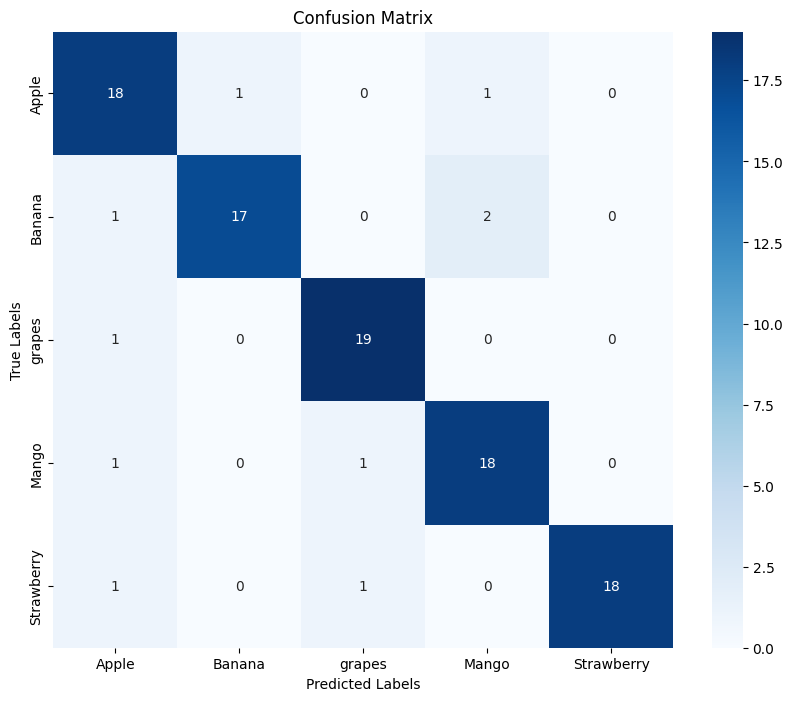

In [11]:
#ResNet50
input_shape = (224, 224, 3)  
num_classes = 5  

base_model = ResNet50(weights=None, include_top=False, input_shape=input_shape)

weights_path = '/kaggle/input/resnet-weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model.load_weights(weights_path)

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.8),
    Dense(num_classes, activation='softmax')  
])

#Train
# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=early_stopping)
# Test
y_pred = model.predict(X_test)
# Convert predictions and true labels back to categorical labels
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)
#print (y_pred_labels)
# Print classification report
print("Classification Report:")
print(classification_report(y_test_labels, y_pred_labels, target_names=categories))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Calculate F1 score
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
print(f'F1 Score: {f1}')
# Calculate and plot confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



# **Output.csv**

In [ ]:
# Output directory
output_directory = '/kaggle/output'

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Extract file names without extension from the test image paths
image_names_without_extension = [os.path.splitext(os.path.basename(path))[0] for path in imgs_paths]

# Convert the predicted labels back to category names using label_encoder
predicted_categories = label_encoder.inverse_transform(y_pred_labels)

# Create a DataFrame with image names (without extension) and predicted labels
results_df = pd.DataFrame({
    'Image_id': image_names_without_extension,
    'Label': predicted_categories
})

# Save the DataFrame to a CSV file
output_file_path = os.path.join(output_directory, 'predictions.csv')
results_df.to_csv('/kaggle/output/predictions.csv', index=False)

# Display the first few rows of the results DataFrame
print(results_df.head())
print(f"Predictions saved to: {output_file_path}")